Import Libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


Define the constants and initial conditions

In [6]:
length = 1.0  # Length of the rod
time_end = 4 # End time
num_points = 10 # Number of spatial points
#num_steps = 200000 # Number of time steps
#L_fusion = 3.9e3 # J/kg
L_fusion = 389e3 # J/kg
k = 109  # W/m-K
# Material properties
rho = 2760.0  # Density of AL380 (kg/m^3)
cp = 963.0  # Specific heat of aluminum (J/kg-K)
alpha = k / (rho * cp)  # Thermal diffusivity
T_L = 866.0   #  K -Liquidus Temperature (593 c)
T_S = 811.0   # K- Solidus Temperature (538 C)
#print(alpha)


# Spatial and time discretisation

#print(cfl)
#num_steps = round(time_end/cfl)+1

dx = length / (num_points - 1)
#dt = time_end/num_steps
dt = abs(0.5 *(dx**2/alpha))
num_steps = round(time_end/dt)
print(num_steps)
cfl = 0.5 *(dx**2/alpha)
#dt = time_end / num_steps
#time_steps = np.linspace(0, time_end, num_steps + 1)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('satibility criteria not satisfied')
    sys.exit()

0
stability criteria satisfied


Defining the simulation field and initilisation of the temperatures

In [7]:
# Initial temperature and phase fields
temperature = np.full(num_points, 963.0)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
temperature[-1] = 313.0 #(40 C)
phase[-1] = 1.0

temperature[0] = 313.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

#print(temperature_history,phi_history)

Solving the heat transfer equation and phase change using numerical methods

In [8]:
# Finite difference method

for m in range(1, num_steps+1):  # time loop
    for n in range(1,num_points-1):  # space loop, adjusted range
        #print(f"Step {m}, point {n},Temperature: {temperature}, Phase: {phase}")
        if temperature[n] >= T_L:
            temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
            phase[n] = 0
         
            #print(m,n,temperature[n],phase[n])
        elif T_S < temperature[n] < T_L:
            temperature[n] = temperature[n] - ((alpha * dt*(T_L-T_S)) / (rho*L_fusion*dx**2) * (temperature[n+1] - 2 * temperature[n] + temperature[n-1]))
            phase[n] = (T_L - temperature[n]) / (T_L - T_S)
        #print(m,n,temperature[n],phase[n])
         
        elif temperature[n]<T_S:
            temperature[n] = temperature[n] + ((alpha * dt) / dx**2 )* (temperature[n+1] - 2 * temperature[n] + temperature[n-1])
            phase[n] = 1
            
        else:
            print("ERROR: should not be here")
         
           # print(m,n,temperature[n],phase[n])
    temperature_history.append(temperature.copy())
    phi_history.append(phase.copy())
    #Print for debugging
    #print(f"Step {m}, space{n},Temperature: {temperature}, Phase: {phase}")


#print(temperature_history)
#print(phi_history)




Plot the Results

Temperature History Shape: (1, 10)
Phi History Shape: (1, 10)
Transposed Temperature History Shape: (10, 1)
Transposed Phi History Shape: (10, 1)


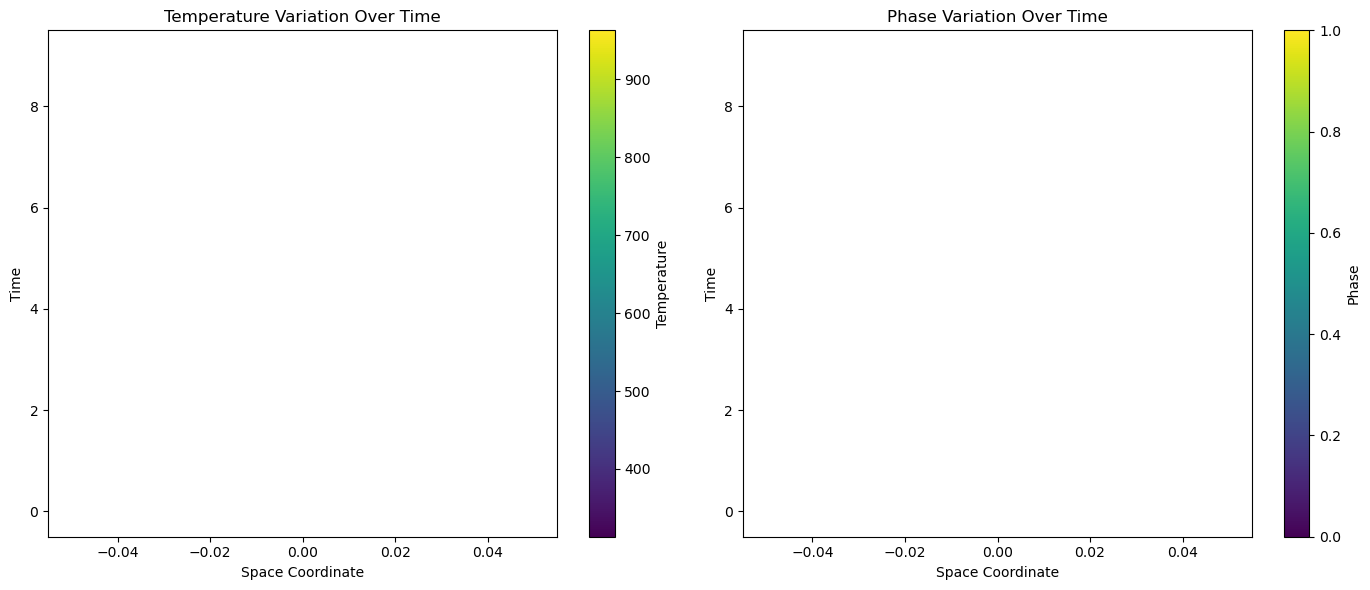

In [9]:
# Assuming you have temperature_history and phi_history as lists of arrays
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)

# Check the shape of temperature_history and phi_history
print("Temperature History Shape:", temperature_history.shape)
print("Phi History Shape:", phi_history.shape)

# Assuming temperature_history and phi_history have dimensions (time, space)
# If needed, transpose the arrays to match the expected dimensions of pcolormesh
temperature_history = temperature_history.T
phi_history = phi_history.T

# Check the new shape after transposing
print("Transposed Temperature History Shape:", temperature_history.shape)
print("Transposed Phi History Shape:", phi_history.shape)

# Create a meshgrid for space and time coordinates
space_coord, time_coord = np.meshgrid(np.arange(temperature_history.shape[1]), np.arange(temperature_history.shape[0]))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, temperature_history, cmap='viridis')
ax1.set_xlabel('Space Coordinate')
ax1.set_ylabel('Time')
ax1.set_title('Temperature Variation Over Time')
fig.colorbar(im1, ax=ax1, label='Temperature')

# Plot the phase history on the right subplot
im2 = ax2.pcolormesh(space_coord, time_coord, phi_history, cmap='viridis')
ax2.set_xlabel('Space Coordinate')
ax2.set_ylabel('Time')
ax2.set_title('Phase Variation Over Time')
fig.colorbar(im2, ax=ax2, label='Phase')

plt.tight_layout()
plt.show()

Saving to CSV files

In [6]:
# Save data to CSV file
csv_filename = 'heat_transfer_data_with_time.csv'

with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Spatial Coordinate (x)', *time_steps])
    csv_writer.writerows(np.column_stack((np.linspace(0, length, num_points), *temperature_history)))

print(f'Data saved to {csv_filename}')

# Save data to CSV file
csv_filename = 'phase_change_data_with_time.csv'

with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Spatial Coordinate (x)', *time_steps])
    csv_writer.writerows(np.column_stack((np.linspace(0, length, num_points), *phi_history)))

print(f'Data saved to {csv_filename}')

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 100 and the array at index 1 has size 1000001

Machine Learning using SVR

In [ ]:
raw_data =  pd.read_csv('heat_transfer_data_with_time.csv') #Read the data
#print(raw_data.head)

X1 = raw_data['Spatial Coordinate (x)'].values # Get the spatial coordinate values
print(len(X1))
X2 = np.arange(0,time_end +dt,dt) # Get the time values
print(len(X2))
#y = np.zeros(len(X1)*len(X2))
#print(len(y))

y_data = raw_data.iloc[0:,1:].values.ravel()    # Get the temperature values
#y = y_data.flatten()
print(y_data)


ftr = list(itertools.product(X1,X2)) #  Get the spatial and time coordinate values
feature = np.array(ftr) # Convert to numpy array

X_train, X_test, y_train, y_test = train_test_split(feature, y_data, test_size=0.2, random_state=42)

Training of SVR

In [ ]:
svr_rbf = svm.SVR(kernel="rbf", C=2000, gamma=100, epsilon=0.1)  # epsilon is the margin of deviation from the regression curve

svr_rbf.fit(X_train, y_train)

y_pred = svr_rbf.predict(feature)
rmse = np.sqrt(mean_squared_error(y_data, y_pred))

y_pred2 = svr_rbf.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
print("RMSE: %f" % (rmse))
print("RMSE2: %f" % (rmse2))
# Visualization (for 2D data)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(feature[:, 0], feature[:, 1], y_data, label='Actual', marker='x')
ax.scatter(feature[:, 0], feature[:, 1], y_pred, label='Predicted', marker='o')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')
ax.legend()

plt.show()
